In [1]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from tabulate import tabulate

# CNN Methodology

## Loading in data

In [2]:
csv_folder_dir = "data/csv/out_of_sample/"
csv_list = [x for x in os.listdir(csv_folder_dir) if not x.startswith(".")]

prices_df = None

for csv_name in csv_list:
    csv_dir = os.path.join(csv_folder_dir, csv_name)
    current_df = pd.read_csv(csv_dir, 
                             usecols=['Date', 'Close'],
                             parse_dates=['Date'])
    current_df.rename(columns={'Close': f"{csv_name[:-4]}"}, inplace=True)
    
    # Merge the current DataFrame with the final DataFrame
    if prices_df is None:
        prices_df = current_df  # Initialize with the first DataFrame
    else:
        prices_df = pd.merge(prices_df, current_df, on='Date', how='outer')  # Merge on 'Date'    

In [3]:
prices_df.head(3)

,Date,CSCO,UAL,TROW,ISRG,NVR,TPR,DVN,CE,MRO,...,WM,DOV,CRM,PGR,WAT,IEX,BWA,LRCX,BLK,PPL
0,2021-01-04,43.959999,41.630001,147.690002,266.666656,4040.649902,32.709999,16.129999,125.930000,6.83,...,114.830002,123.339996,220.309998,97.129997,250.149994,195.309998,33.503521,47.801998,710.820007,27.580000
1,2021-01-05,43.980000,43.400002,149.089996,268.350006,4008.909912,32.520000,17.360001,131.600006,7.45,...,115.209999,124.059998,221.520004,96.949997,255.429993,194.929993,34.295776,49.455002,714.580017,27.610001
2,2021-01-06,44.400002,43.540001,151.529999,264.263336,3966.489990,34.320000,18.320000,136.550003,7.50,...,117.760002,127.559998,216.149994,98.790001,262.470001,202.179993,35.360916,49.648998,734.960022,28.110001


## Use model to infer on out of sample images

In [4]:
from tensorflow.keras.models import load_model

model = load_model("models/60-day.keras")
model.summary()

2024-12-02 23:17:55.924315: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-12-02 23:17:55.924339: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-02 23:17:55.924344: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-02 23:17:55.924379: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-02 23:17:55.924391: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 180, 64)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 180, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 96, 180, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 180, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 180, 128)   │       123,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 180, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 180, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 180, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 180, 256)   │       491,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 180, 256)   │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16, 180, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 180, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 180, 512)    │     1,966,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 180, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 8, 180, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 180, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 368640)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │       368,641 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,860,805 (33.80 MB)

 Trainable params: 2,952,961 (11.26 MB)

 Non-trainable params: 1,920 (7.50 KB)

 Optimizer params: 5,905,924 (22.53 MB)

In [5]:
%%time
image_dir = "data/images_small/out_of_sample/60-day/"
dirist = [x for x in os.listdir(image_dir) if not x.startswith(".")]
predictions_dict = {}
for folder_name in tqdm(dirist):
    folder_dir = os.path.join(image_dir, folder_name)
    current_images = []
    # load images
    for file_name in os.listdir(folder_dir):
        file_dir = os.path.join(folder_dir, file_name)
        img = cv2.imread(file_dir, cv2.IMREAD_GRAYSCALE)
        current_images.append(img)
    # get model prediction
    current_images = np.array(current_images)
    current_predictions = model.predict(current_images, verbose=0).flatten()
    predictions_dict[folder_name] = current_predictions

#-------------
predictions_df = pd.DataFrame(predictions_dict)

del model

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 489/489 [00:44<00:00, 10.98it/s]

CPU times: user 14.7 s, sys: 8.21 s, total: 22.9 s
Wall time: 44.6 s


In [6]:
new_index = range(60, 60 * (len(predictions_df) + 1), 60)
predictions_df.index = new_index
predictions_df.head(3)

,CTAS,WELL,VZ,AMZN,CNP,RCL,CAT,TFC,AAPL,PANW,...,EXPE,HUM,HST,NVR,STT,CCI,SCHW,STZ,MSCI,GLW
60,0.689468,0.395064,0.103303,0.498411,0.548489,0.460255,0.380563,0.448737,0.720263,0.741212,...,0.482520,0.635263,0.661687,0.439215,0.468722,0.556208,0.426316,0.376236,0.369940,0.398744
120,0.390582,0.310491,0.396847,0.507335,0.052511,0.594494,0.517154,0.565652,0.606552,0.174914,...,0.567587,0.364417,0.579999,0.558804,0.478388,0.682713,0.323823,0.518802,0.215183,0.559390
180,0.415384,0.620867,0.334339,0.538638,0.385683,0.521046,0.551358,0.679448,0.762148,0.538884,...,0.527549,0.792051,0.651112,0.035175,0.258627,0.494402,0.572844,0.428582,0.547452,0.561494


---
### For the sake of clarity:
- `predictions_df` --> One row in this df, represents the **probability to have a positive returns in the next time period** (in this case 5 days), its a probability that we calculate based on one week worth of data, and we know that the week starts at the index.

*EXAMPLE:* So the first row of `predictions_df` has `index = 5`, so we know that it its the probability to have a positive returns in the time frame described from indeces `10` to `15` in the `prices_df`.
> 
> `predictions_df.index(5)` is calculated based on `price_df.iloc[5:10]` and its the probability to have a positive return in the next 5 day window `price_df.iloc[10:15]`


We start our simulation at index 10 of our price_df, we use only the information we have up untill that point and among all the firms in the sp500, we 
- **buy** the top decile with highest probability to have a positive return
- **short** the bottome decile with the lowest probability to have a positive return

(the top decile and bottom decile contain 50 companies each, since we have 500 of them)

---

In [7]:
window_size = 60
long_returns = []
short_returns = []
for today in tqdm(range(60, len(prices_df) - 2 * window_size, 60)):
    current_probabilities = predictions_df.loc[today]
    
    to_buy = list(current_probabilities.nlargest(50).index)
    to_sell = list(current_probabilities.nsmallest(50).index)
    
    long_stocks = prices_df[to_buy].copy()
    short_stocks = prices_df[to_sell].copy()
    
    long_pos_start = long_stocks.iloc[today + window_size]
    long_pos_end = long_stocks.iloc[today + 2*window_size]
    long_pos_diff = (long_pos_end - long_pos_start)/long_pos_start
    
    short_pos_start = short_stocks.iloc[today + window_size]
    short_pos_end = short_stocks.iloc[today + 2*window_size]
    short_pos_diff = -(short_pos_end - short_pos_start)/short_pos_start

    long_portfolio_return = long_pos_diff.mean()
    short_portfolio_return = short_pos_diff.mean()

    long_returns.append(long_portfolio_return)
    short_returns.append(short_portfolio_return)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 262.09it/s]


In [8]:
CNN_portfolio = pd.DataFrame({"Long portfolio": long_returns,
                              "Short portfolio": short_returns})
CNN_portfolio["Long Short portfolio"] = CNN_portfolio["Long portfolio"] + CNN_portfolio["Short portfolio"]
CNN_portfolio.head(3)

,Long portfolio,Short portfolio,Long Short portfolio
0,-0.023114,-0.004621,-0.027735
1,0.100301,-0.052379,0.047922
2,-0.022567,0.030244,0.007678


## Visualizing results 

In [9]:
mean_returns_bps = CNN_portfolio.mean() * 10000  
cnn_monthly_return_data = [[portfolio, f"{mean_return:+.2f} bps"]
        for portfolio, mean_return in mean_returns_bps.items()]
cnn_monthly_return_headers = ["Portfolio", "Avg Weekely Return"]
del mean_returns_bps

print(tabulate(cnn_monthly_return_data, headers=cnn_monthly_return_headers, tablefmt="fancy_grid"))

╒══════════════════════╤══════════════════════╕
│ Portfolio            │ Avg Weekely Return   │
╞══════════════════════╪══════════════════════╡
│ Long portfolio       │ +192.29 bps          │
├──────────────────────┼──────────────────────┤
│ Short portfolio      │ -250.12 bps          │
├──────────────────────┼──────────────────────┤
│ Long Short portfolio │ -57.83 bps           │
╘══════════════════════╧══════════════════════╛


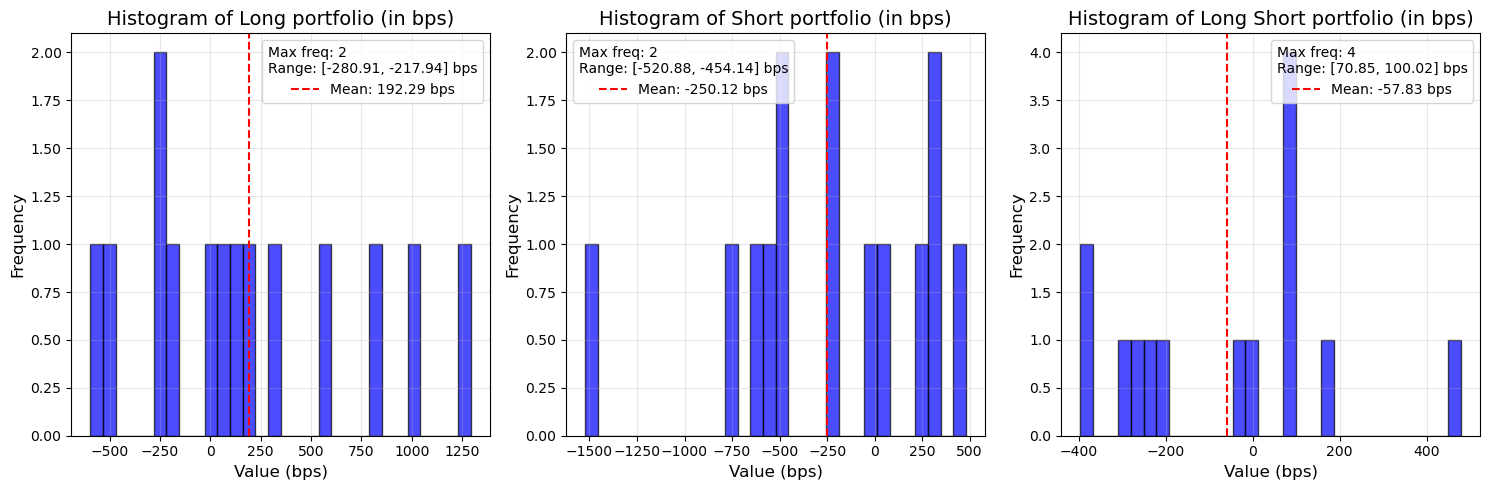

In [10]:
plt.figure(figsize=(15, 5))
columns = list(CNN_portfolio.columns)

for i, column in enumerate(columns, 1):
    plt.subplot(1, len(columns), i)
    
    # Transform probabilities to basis points
    values = CNN_portfolio[column] * 10000
    
    counts, bins, _ = plt.hist(values, bins=30, alpha=0.7, color='blue', edgecolor='black')
    
    mean_value = values.mean()
    plt.axvline(mean_value, color='red', linestyle='--', label=f"Mean: {mean_value:.2f} bps")
    
    max_freq = counts.max()
    max_freq_bin_index = np.argmax(counts)
    max_freq_bin_start = bins[max_freq_bin_index]
    max_freq_bin_end = bins[max_freq_bin_index + 1]
    max_freq_label = f"Max freq: {max_freq:.0f}\nRange: [{max_freq_bin_start:.2f}, {max_freq_bin_end:.2f}] bps"
    
    plt.legend(title=max_freq_label, fontsize=10)
    
    plt.title(f"Histogram of {column} (in bps)", fontsize=14)
    plt.xlabel("Value (bps)", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
cnn_long_portfolio = 1000
cnn_long_portfolio_history = []
cnn_long_short_portfolio = 1000
cnn_long_short_portfolio_history = []
for _, row in CNN_portfolio.iterrows():
    cnn_long_portfolio *= (1 + row["Long portfolio"]) 
    cnn_long_short_portfolio *= (1 + row["Long Short portfolio"])
    cnn_long_portfolio_history.append(cnn_long_portfolio)
    cnn_long_short_portfolio_history.append(cnn_long_short_portfolio)

In [12]:
# Final and initial values for long and long-short portfolios
initial_value = 1000  # Initial portfolio value
cnn_long_final_value = cnn_long_portfolio_history[-1]
cnn_long_short_final_value = cnn_long_short_portfolio_history[-1]

# Total period in years
total_years = 3 + 10 / 12  # 3 years and 10 months

# Calculate overall and yearly returns
cnn_long_overall_return = (cnn_long_final_value / initial_value) - 1
cnn_long_short_overall_return = (cnn_long_short_final_value / initial_value) - 1

cnn_long_avg_yearly_return = (cnn_long_final_value / initial_value) ** (1 / total_years) - 1
cnn_long_short_avg_yearly_return = (cnn_long_short_final_value / initial_value) ** (1 / total_years) - 1

In [13]:
cnn_data = [["Long Portfolio", f"{cnn_long_overall_return:.2%}", f"{cnn_long_avg_yearly_return:.2%}"],
            ["Long-Short Portfolio", f"{cnn_long_short_overall_return:.2%}", f"{cnn_long_short_avg_yearly_return:.2%}"]]
cnn_headers = ["Portfolio", "Overall Return", "Avg Yearly Return"]

print(tabulate(cnn_data, headers=cnn_headers, tablefmt="fancy_grid"))

╒══════════════════════╤══════════════════╤═════════════════════╕
│ Portfolio            │ Overall Return   │ Avg Yearly Return   │
╞══════════════════════╪══════════════════╪═════════════════════╡
│ Long Portfolio       │ 28.07%           │ 6.67%               │
├──────────────────────┼──────────────────┼─────────────────────┤
│ Long-Short Portfolio │ -8.17%           │ -2.20%              │
╘══════════════════════╧══════════════════╧═════════════════════╛


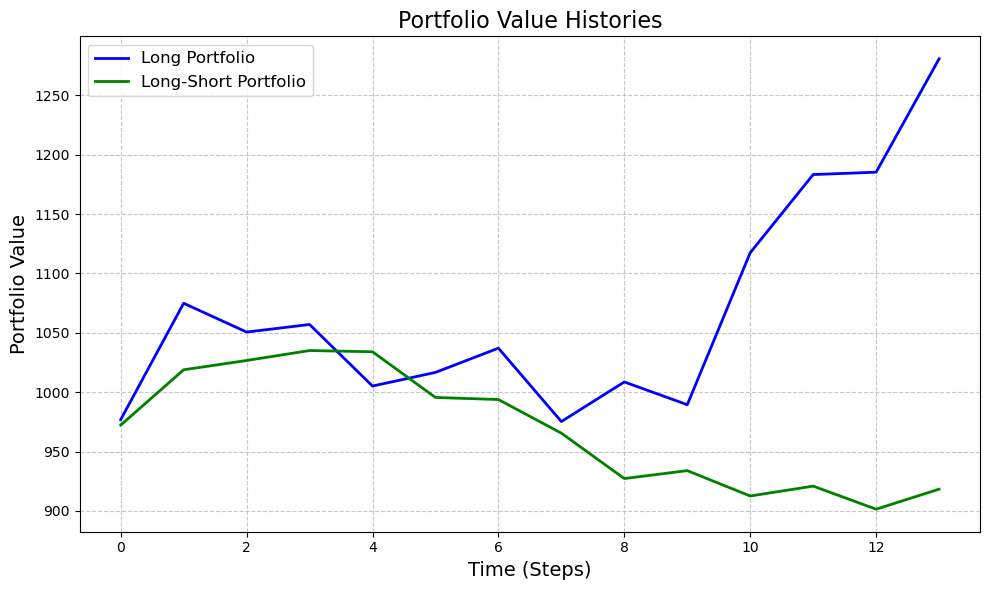

In [14]:
plt.figure(figsize=(10, 6))

# Plot the histories
plt.plot(cnn_long_portfolio_history, label="Long Portfolio", color='blue', linewidth=2)
plt.plot(cnn_long_short_portfolio_history, label="Long-Short Portfolio", color='green', linewidth=2)

# Add labels, legend, and title
plt.title("Portfolio Value Histories", fontsize=16)
plt.xlabel("Time (Steps)", fontsize=14)
plt.ylabel("Portfolio Value", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

# Random Portfolio

In [ ]:
rand_portfolio = pd.read_csv("data/random_portfolio.csv")
rand_portfolio.head(3)

In [ ]:
rand_long_portfolio = 1000
rand_long_portfolio_history = []
rand_long_short_portfolio = 1000
rand_long_short_portfolio_history = []
for _, row in rand_portfolio.iterrows():
    rand_long_portfolio *= (1 + row["Long portfolio"]) 
    rand_long_short_portfolio *= (1 + row["Long Short portfolio"])
    rand_long_portfolio_history.append(rand_long_portfolio)
    rand_long_short_portfolio_history.append(rand_long_short_portfolio)

In [ ]:
# Initializing variables for random portfolio
rand_initial_value = 1000  # Initial portfolio value
rand_long_final_value = rand_long_portfolio_history[-1]
rand_long_short_final_value = rand_long_short_portfolio_history[-1]

# Total period in years
total_years = 3 + 10 / 12  # 3 years and 10 months

# Calculate overall and yearly returns for random portfolio
rand_long_overall_return = (rand_long_final_value / rand_initial_value) - 1
rand_long_short_overall_return = (rand_long_short_final_value / rand_initial_value) - 1

rand_long_avg_yearly_return = (rand_long_final_value / rand_initial_value) ** (1 / total_years) - 1
rand_long_short_avg_yearly_return = (rand_long_short_final_value / rand_initial_value) ** (1 / total_years) - 1

In [ ]:
rand_portfolio_data = [["Random Long Portfolio", f"{rand_long_overall_return:.2%}", f"{rand_long_avg_yearly_return:.2%}"],
                       ["Random Long-Short Portfolio", f"{rand_long_short_overall_return:.2%}", f"{rand_long_short_avg_yearly_return:.2%}"]]

headers = ["Portfolio", "Overall Return", "Avg Yearly Return"]
print(tabulate(rand_portfolio_data, headers=headers, tablefmt="fancy_grid", colalign=("center", "center", "center")))

# Uniform Portfolio

In [ ]:
unif_portfolio = pd.read_csv("data/unif_portfolio.csv")
unif_portfolio.head(3)

In [ ]:
unif_long_portfolio = 1000
unif_long_portfolio_history = []
unif_long_short_portfolio = 1000
unif_long_short_portfolio_history = []
for _, row in unif_portfolio.iterrows():
    unif_long_portfolio *= (1 + row["Long portfolio"]) 
    unif_long_short_portfolio *= (1 + row["Long Short portfolio"])
    unif_long_portfolio_history.append(unif_long_portfolio)
    unif_long_short_portfolio_history.append(unif_long_short_portfolio)

In [ ]:
# Initializing variables for uniform portfolio
unif_initial_value = 1000  # Initial portfolio value
unif_long_final_value = unif_long_portfolio_history[-1]
unif_long_short_final_value = unif_long_short_portfolio_history[-1]

# Total period in years
total_years = 3 + 10 / 12  # 3 years and 10 months

# Calculate overall and yearly returns for uniform portfolio
unif_long_overall_return = (unif_long_final_value / unif_initial_value) - 1
unif_long_short_overall_return = (unif_long_short_final_value / unif_initial_value) - 1

unif_long_avg_yearly_return = (unif_long_final_value / unif_initial_value) ** (1 / total_years) - 1
unif_long_short_avg_yearly_return = (unif_long_short_final_value / unif_initial_value) ** (1 / total_years) - 1

In [ ]:
unif_portfolio_data = [
    ["Uniform Long Portfolio", f"{unif_long_overall_return:.2%}", f"{unif_long_avg_yearly_return:.2%}"],
    ["Uniform Long-Short Portfolio", f"{unif_long_short_overall_return:.2%}", f"{unif_long_short_avg_yearly_return:.2%}"],
]

headers = ["Portfolio", "Overall Return", "Avg Yearly Return"]
print(tabulate(unif_portfolio_data, headers=headers, tablefmt="fancy_grid", colalign=("center", "center", "center")))


# SP500

In [ ]:
spx_portfolio = pd.read_csv("data/spx_portfolio.csv")
spx_portfolio.head(3)

In [ ]:
spx_long_portfolio = 1000
spx_long_portfolio_history = []
for _, row in spx_portfolio.iterrows():
    spx_long_portfolio *= (1 + row["Long portfolio"]) 
    spx_long_portfolio_history.append(spx_long_portfolio)

In [ ]:
# Initializing variables for SPX portfolio
spx_initial_value = 1000  # Initial portfolio value
spx_long_final_value = spx_long_portfolio_history[-1]

# Total period in years
total_years = 3 + 10 / 12  # 3 years and 10 months

# Calculate overall and yearly returns for SPX portfolio
spx_long_overall_return = (spx_long_final_value / spx_initial_value) - 1
spx_long_avg_yearly_return = (spx_long_final_value / spx_initial_value) ** (1 / total_years) - 1

In [ ]:
spx_portfolio_data = [
    ["SPX Long Portfolio", f"{spx_long_overall_return:.2%}", f"{spx_long_avg_yearly_return:.2%}"],
]

headers = ["Portfolio", "Overall Return", "Avg Yearly Return"]
print(tabulate(spx_portfolio_data, headers=headers, tablefmt="fancy_grid", colalign=("center", "center", "center")))


# PORTFOLIO COMPARISON

In [ ]:
plt.figure(figsize=(10, 6))

# Plot the histories for all portfolios
plt.plot(cnn_long_portfolio_history, label="CNN Long Portfolio", color='blue', linewidth=2)
plt.plot(rand_long_portfolio_history, label="Random Long Portfolio", color='red', linewidth=2)
plt.plot(unif_long_portfolio_history, label="Uniform Long Portfolio", color='purple', linewidth=2)
plt.plot(spx_long_portfolio_history, label="SPX Long Portfolio", color='black', linewidth=2)

# Add labels, legend, and title
plt.title("Portfolio Value Histories", fontsize=16)
plt.xlabel("Time (Steps)", fontsize=14)
plt.ylabel("Portfolio Value", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()
